<a href="https://colab.research.google.com/github/Manisha021095/Manisha_INFO5731_Fall2022/blob/main/In_class_exercise_04_11032022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The fourth in-class-exercise (40 points in total, 11/03/2022)**

Question description: Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks:

## (1) (10 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [ ]:
# Run in python console
import nltk; nltk.download('stopwords')


import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

!pip install pyLDAvis

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 4.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=15b99b27550fbb672278e9363fd08701a78d72f6a3ffe39c2183ef806179f67d
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=68a4068e82e1f1789ecd33d3efe3aabd84ac107b88b99040d9c058158164f431
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built pyLDAvis sklearn


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [9]:
df = pd.read_csv('/content/drive/MyDrive/Nokia Reviews.csv')
df.dropna(how='any', inplace=True)
print(df.Review)
df.head()

0      This 55" 4K Nokia TV at this price point comes...
1      I must say it is best decision to by Nokia TV....
2      Flipcart delivered the Product in less than 24...
3      Pros1) Picture Quality is good, micro dimming ...
4      Value for money ....1) This tv has Everything ...
                             ...                        
995    I have reviewed ofter using 30 days. Tv is rea...
996    very good TV, Everything fine. Go for it.READ ...
997    The product does well for a budget TV.Good pic...
998                                   No thanksREAD MORE
999                                        goodREAD MORE
Name: Review, Length: 1000, dtype: object


,Glimpse of Review,Review
0,Review from Technology Gyan: Almost everything...,"This 55"" 4K Nokia TV at this price point comes..."
1,Brilliant,I must say it is best decision to by Nokia TV....
2,Best in the market!,Flipcart delivered the Product in less than 24...
3,Pretty good,"Pros1) Picture Quality is good, micro dimming ..."
4,Terrific purchase,Value for money ....1) This tv has Everything ...


In [10]:
# Convert to list
data = df.Review.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['This 55" 4K Nokia TV at this price point comes with almost everything we '
 'expect from a TV in todays time. Here are a few Pros and Cons, according to '
 'what I experienced:-Pros: 1) Great quality display (Thin Bezels): The '
 'presence of almost no to very thin bezels changes the whole experience of '
 'viewing. I played high resolution wildlife videos on YouTube and was amazed '
 'to see the details and colours.2) Sound by JBL (front firing speakers): I '
 'could experience clear vocal tones in dialogues a...READ MORE']


In [11]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['this', 'nokia', 'tv', 'at', 'this', 'price', 'point', 'comes', 'with', 'almost', 'everything', 'we', 'expect', 'from', 'tv', 'in', 'todays', 'time', 'here', 'are', 'few', 'pros', 'and', 'cons', 'according', 'to', 'what', 'experienced', 'pros', 'great', 'quality', 'display', 'thin', 'bezels', 'the', 'presence', 'of', 'almost', 'no', 'to', 'very', 'thin', 'bezels', 'changes', 'the', 'whole', 'experience', 'of', 'viewing', 'played', 'high', 'resolution', 'wildlife', 'videos', 'on', 'youtube', 'and', 'was', 'amazed', 'to', 'see', 'the', 'details', 'and', 'colours', 'sound', 'by', 'jbl', 'front', 'firing', 'speakers', 'could', 'experience', 'clear', 'vocal', 'tones', 'in', 'dialogues', 'read', 'more']]


In [12]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['this', 'nokia', 'tv', 'at', 'this', 'price', 'point', 'comes', 'with', 'almost', 'everything', 'we', 'expect', 'from', 'tv', 'in', 'todays', 'time', 'here', 'are', 'few', 'pros', 'and', 'cons', 'according', 'to', 'what', 'experienced', 'pros', 'great', 'quality', 'display', 'thin', 'bezels', 'the', 'presence', 'of', 'almost', 'no', 'to', 'very', 'thin', 'bezels', 'changes', 'the', 'whole', 'experience', 'of', 'viewing', 'played', 'high', 'resolution', 'wildlife', 'videos', 'on', 'youtube', 'and', 'was', 'amazed', 'to', 'see', 'the', 'details', 'and', 'colours', 'sound', 'by', 'jbl', 'front', 'firing', 'speakers', 'could', 'experience', 'clear', 'vocal', 'tones', 'in', 'dialogues', 'read', 'more']


In [13]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [14]:
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

/usr/local/lib/python3.7/dist-packages/spacy/language.py:1899: UserWarning: [W123] Argument disable with value ['parser', 'ner'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  config_value=config["nlp"][key],


[['price', 'point', 'come', 'almost', 'expect', 'tv', 'today', 'time', 'pro', 'con', 'accord', 'experienced', 'pro', 'great', 'quality', 'display', 'thin', 'bezel', 'presence', 'almost', 'thin', 'bezel', 'change', 'whole', 'experience', 'view', 'play', 'high', 'resolution', 'wildlife', 'video', 'youtube', 'amazed', 'see', 'detail', 'colour', 'sound', 'jbl', 'front', 'fire', 'speaker', 'experience', 'clear', 'vocal', 'tone', 'dialogue', 'read']]


In [15]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1)]]


In [16]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [17]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.090*"goodread" + 0.033*"waste" + 0.026*"name" + 0.023*"patch" + '
  '0.022*"resolve" + 0.022*"team" + 0.021*"word" + 0.020*"buying" + '
  '0.020*"people" + 0.016*"spot"'),
 (1,
  '0.062*"problem" + 0.042*"screen" + 0.040*"issue" + 0.027*"black" + '
  '0.026*"see" + 0.024*"lead" + 0.024*"video" + 0.022*"hang" + 0.022*"lot" + '
  '0.022*"button"'),
 (2,
  '0.096*"great" + 0.052*"year" + 0.040*"quite" + 0.040*"awesomeread" + '
  '0.038*"performance" + 0.037*"flipkart" + 0.031*"product" + '
  '0.027*"specially" + 0.024*"buyread" + 0.024*"bluetooth"'),
 (3,
  '0.139*"installation" + 0.079*"delivery" + 0.075*"flipkart" + 0.059*"thank" '
  '+ 0.041*"do" + 0.039*"day" + 0.037*"happy" + 0.031*"deliver" + '
  '0.027*"jeeve" + 0.019*"instal"'),
 (4,
  '0.138*"service" + 0.047*"flipkart" + 0.041*"face" + 0.036*"sale" + '
  '0.032*"still" + 0.029*"totally" + 0.028*"poor" + 0.027*"late" + '
  '0.026*"provide" + 0.022*"nokia"'),
 (5,
  '0.123*"bad" + 0.105*"worth" + 0.042*"m" + 0.035*"show"

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [32]:
!apt install unzip
!unzip -q /content/drive/MyDrive/mallet-2.0.8.zip -d my

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
mallet_path = '/content/my/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [35]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('tv', 0.3816982687551525),
   ('great', 0.08161582852431987),
   ('nokia', 0.07831821929101401),
   ('inch', 0.026380873866446827),
   ('feature', 0.026380873866446827),
   ('smart', 0.025556471558120363),
   ('find', 0.018136850783182192),
   ('view', 0.01731244847485573),
   ('recommend', 0.01483924154987634),
   ('decision', 0.013190436933223413)]),
 (1,
  [('issue', 0.09600614439324116),
   ('video', 0.060675883256528416),
   ('review', 0.0445468509984639),
   ('make', 0.03533026113671275),
   ('bleed', 0.03379416282642089),
   ('update', 0.03302611367127496),
   ('clarity', 0.029953917050691243),
   ('app', 0.029185867895545316),
   ('super', 0.026881720430107527),
   ('audio', 0.019969278033794162)]),
 (2,
  [('sound', 0.18267581475128644),
   ('read', 0.10034305317324185),
   ('amazing', 0.07632933104631218),
   ('experience', 0.05060034305317324),
   ('lead', 0.032590051457975985),
   ('love', 0.030017152658662092),
   ('feel', 0.024013722126929673),
   ('thing', 0.022

In [36]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

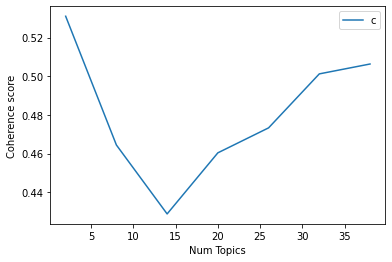

In [37]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [38]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5311
Num Topics = 8  has Coherence Value of 0.4644
Num Topics = 14  has Coherence Value of 0.4288
Num Topics = 20  has Coherence Value of 0.4604
Num Topics = 26  has Coherence Value of 0.4733
Num Topics = 32  has Coherence Value of 0.5012
Num Topics = 38  has Coherence Value of 0.5064


In [39]:
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.212*"product" + 0.152*"excellent" + 0.084*"bad" + 0.055*"happy" + '
  '0.050*"super" + 0.035*"goodread" + 0.027*"read" + 0.024*"waste" + '
  '0.019*"design" + 0.018*"nokiaread"'),
 (1,
  '0.066*"experience" + 0.065*"speaker" + 0.049*"nice" + 0.047*"give" + '
  '0.040*"lead" + 0.037*"build" + 0.031*"feel" + 0.029*"superb" + 0.027*"home" '
  '+ 0.026*"play"'),
 (2,
  '0.161*"sound" + 0.152*"jbl" + 0.145*"awesome" + 0.046*"love" + '
  '0.042*"clarity" + 0.032*"budget" + 0.027*"pro" + 0.022*"system" + '
  '0.021*"view" + 0.020*"movie"'),
 (3,
  '0.157*"read" + 0.091*"month" + 0.087*"work" + 0.070*"review" + '
  '0.043*"picture" + 0.033*"perfect" + 0.025*"usage" + 0.022*"lot" + '
  '0.021*"complete" + 0.021*"satisfied"'),
 (4,
  '0.122*"installation" + 0.107*"flipkart" + 0.089*"day" + 0.071*"service" + '
  '0.068*"delivery" + 0.050*"support" + 0.031*"jeeve" + 0.028*"deliver" + '
  '0.024*"customer" + 0.022*"guy"'),
 (5,
  '0.254*"tv" + 0.128*"price" + 0.105*"amazing" + 0.056*"rang

In [40]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.1765,"experience, speaker, nice, give, lead, build, ...","This 55"" 4K Nokia TV at this price point comes..."
1,1,6.0,0.1212,"good, read, quality, money, thing, fast, fanta...",I must say it is best decision to by Nokia TV....
2,2,4.0,0.1423,"installation, flipkart, day, service, delivery...",Flipcart delivered the Product in less than 24...
3,3,1.0,0.1415,"experience, speaker, nice, give, lead, build, ...","Pros1) Picture Quality is good, micro dimming ..."
4,4,1.0,0.1744,"experience, speaker, nice, give, lead, build, ...",Value for money ....1) This tv has Everything ...
5,5,2.0,0.1249,"sound, jbl, awesome, love, clarity, budget, pr...",We use 7500F series 55 inch tv Nokia is bettre...
6,6,1.0,0.1686,"experience, speaker, nice, give, lead, build, ...",Great TV. review after second day of installat...
7,7,1.0,0.1054,"experience, speaker, nice, give, lead, build, ...",its excellent tv worth for every penny i think...
8,8,5.0,0.1067,"tv, price, amazing, range, tvread, inch, featu...",they are providing amazon prime support with a...
9,9,2.0,0.1391,"sound, jbl, awesome, love, clarity, budget, pr...",Ifff u r planing for premium tv under 40k noki...


In [41]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.2578,"product, excellent, bad, happy, super, goodrea...",Tv is very good I will refer this to take.Inst...
1,1.0,0.1832,"experience, speaker, nice, give, lead, build, ...",I love the sound it produces... I mean beat by...
2,2.0,0.1656,"sound, jbl, awesome, love, clarity, budget, pr...",I was in confusion whether to go for LG or Nok...
3,3.0,0.2801,"read, month, work, review, picture, perfect, u...",The audio and display quality is very good. Ho...
4,4.0,0.3019,"installation, flipkart, day, service, delivery...",After using around 1 month I am writing this c...


In [42]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,1.0,"experience, speaker, nice, give, lead, build, ...",124.0,0.124
1.0,6.0,"good, read, quality, money, thing, fast, fanta...",76.0,0.076
2.0,4.0,"installation, flipkart, day, service, delivery...",92.0,0.092
3.0,1.0,"experience, speaker, nice, give, lead, build, ...",61.0,0.061
4.0,1.0,"experience, speaker, nice, give, lead, build, ...",81.0,0.081
...,...,...,...,...
995.0,12.0,"good, quality, money, sound, nice, expect, lat...",NaN,NaN
996.0,3.0,"read, month, work, review, picture, perfect, u...",NaN,NaN
997.0,3.0,"read, month, work, review, picture, perfect, u...",NaN,NaN
998.0,10.0,"nokia, tv, display, problem, purchase, start, ...",NaN,NaN


## (2) (10 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [43]:
# Write your code here

import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt


In [44]:
def prepare_corpus(doc_clean):
   
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [45]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    #number_of_topics = 20
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=20, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [46]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    coherence_values = []
    model_list = []
    #number_of_topics = 7
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=20, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [47]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    #number_of_topics = 7
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

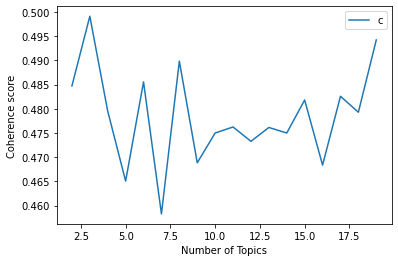

In [48]:
start,stop,step=2,20,1
plot_graph(data_lemmatized,start,stop,step)

In [49]:
number_of_topics=13
words=10
model=create_gensim_lsa_model(data_lemmatized,number_of_topics,words)

[(0, '0.472*"tv" + 0.409*"good" + 0.338*"quality" + 0.313*"sound" + 0.308*"read" + 0.225*"picture" + 0.155*"product" + 0.120*"jbl" + 0.109*"nokia" + 0.103*"buy"'), (1, '-0.719*"tv" + 0.392*"good" + 0.295*"quality" + 0.259*"sound" + 0.206*"picture" + -0.141*"buy" + 0.131*"product" + -0.109*"nokia" + -0.086*"screen" + 0.061*"value"'), (2, '0.772*"good" + -0.290*"quality" + -0.250*"product" + -0.212*"picture" + -0.196*"sound" + -0.181*"read" + -0.153*"awesome" + 0.144*"tv" + -0.115*"excellent" + -0.114*"great"'), (3, '0.663*"product" + -0.363*"quality" + -0.225*"picture" + -0.213*"tv" + 0.185*"installation" + 0.183*"read" + 0.170*"flipkart" + -0.159*"sound" + 0.126*"day" + 0.120*"delivery"'), (4, '-0.463*"issue" + -0.280*"read" + -0.269*"video" + 0.266*"product" + -0.265*"screen" + 0.226*"tv" + -0.195*"get" + 0.179*"quality" + 0.145*"installation" + -0.134*"remote"'), (5, '-0.482*"quality" + 0.314*"jbl" + 0.313*"sound" + -0.290*"bad" + 0.205*"price" + -0.184*"issue" + 0.166*"great" + -0.1

## (3) (10 points) Generate K topics by using  lda2vec, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://nbviewer.org/github/cemoody/lda2vec/blob/master/examples/twenty_newsgroups/lda2vec/lda2vec.ipynb

In [71]:
# Write your code here

from lda2vec import preprocess, Corpus
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [69]:
import pyLDAvis
pyLDAvis.enable_notebook()

In [67]:
npz = np.load(open('topics.pyldavis.npz', 'r'))
dat = {k: v for (k, v) in npz.iteritems()}
dat['vocab'] = dat['vocab'].tolist()

## (4) (10 points) Generate K topics by using BERTopic, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://colab.research.google.com/drive/1FieRA9fLdkQEGDIMYl0I3MCjSUKVF8C-?usp=sharing

In [52]:
# Write your code here

!pip install bertopic


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 90 kB 3.2 MB/s 
     |████████████████████████████████| 636 kB 28.6 MB/s 
     |████████████████████████████████| 88 kB 7.6 MB/s 
     |████████████████████████████████| 85 kB 5.3 MB/s 
     |████████████████████████████████| 5.2 MB 43.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 5.5 MB 32.4 MB/s 
     |████████████████████████████████| 1.3 MB 56.6 MB/s 
     |████████████████████████████████| 163 kB 46.4 MB/s 
     |████████████████████████████████| 7.6 MB 34.5 MB/s 
     |████████████████████████████████| 1.1 MB 56.2 MB/s 
  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp37-cp37m-linux_x86_64.whl size=2340711 sha256=aba013e502536e1d66978f7c4b1a6ca479593e49723866f6e4de9202ecaa4fbb
  Stored in directory: /root/.cache

In [54]:
from bertopic import BERTopic

topic_model = BERTopic(language="english", calculate_probabilities=False, verbose=True)
docs = [str(word) for word in data_lemmatized]
topics, probs = topic_model.fit_transform(docs)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2022-11-06 01:41:52,677 - BERTopic - Transformed documents to Embeddings
2022-11-06 01:42:05,965 - BERTopic - Reduced dimensionality
2022-11-06 01:42:06,026 - BERTopic - Clustered reduced embeddings


In [55]:
freq = topic_model.get_topic_info(); freq.head(10)

,Topic,Count,Name
0,0,898,0_tv_good_read_quality
1,1,54,1_goodread_niceread_bestread_okread
2,2,26,2_productread_good_nice_buyread
3,3,11,3____
4,4,11,4_awesomeread_superbread_fabulousread_amazingread


In [56]:
topic_model.get_topic(0)

[('tv', 0.0735763676330698),
 ('good', 0.06862662543974045),
 ('read', 0.0682963640227169),
 ('quality', 0.06199238554739675),
 ('sound', 0.06062476227942863),
 ('picture', 0.048350701233366655),
 ('product', 0.04811036980174493),
 ('nokia', 0.03226529642893432),
 ('jbl', 0.03196941150924145),
 ('buy', 0.03190056484731465)]

## (5) (10 extra points) Compare the results generated by the four topic modeling algorithms, which one is better? You should explain the reasons in details.

In [61]:
# Write your answer here (no code needed for this question)

# We are surrounded by massive, ever-increasing quantities of text that contain vast amounts of data.

# Many recent methodologies require the text to be highly organized or annotated in order to examine it. This is a demanding and costly task.

# Topic modeling is a branch of natural language processing that can evaluate text without requiring annotation, making it useful for large-scale analysis.

# Latent Dirichlet Allocation is a prominent technique to topic modeling (LDA).

# Topic modeling using LDA is an experimental technique that uses a generative probabilistic process to uncover latent topic structures in text data. These selected subjects can aid comprehension and serve as inputs for future investigation.

# To model subjects, LDA employs Bayesian statistics and Dirichlet distributions in an iterative process.

# The core of LDA is the iterative examination of topic distributions inside texts and word distributions within subjects, which results in the discovery of coherent themes.

# LDA is a popular method for a reason: it has a natural appeal, is simple to implement, and generates good results.

# It also aids in the resolution of supervised learning's primary flaw: the requirement for labeled data.